In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import datetime
import matplotlib.pyplot as plt 
from matplotlib import cm

# Intro

So I pre-processed the data to have exactly the same time resolution and exactly the same time stamps.

We have 5 instruments, 4 of them 2-dimensional. All 2-dimensional data have exactly the same depth levels. I reduced the information to 14 depth levels. 3 out of 4 2-dimensional data have exactly the same variables. There is one 2-dimensional data set that has only 1 variable. 

The only 1-dimensional data set has multiple variables.

The following script uses xarray to read in netcdf data. And it gives you a meta data and visual overview of the data.

After that I extract the information to numpy arrays. Basically each co-variable is 1 numpy array. These arrays have the information of time and depth if 2-dimensional or just time if 1-dimensional. 

Maybe we can start with just 1 co-variable and increase from there. I also extracted day of year and hour of day to add to the list of co-variables.

The point that I am not sure about, which we maybe can discuss going forward: 
    
Lets say I have two time series, temperature and precipitation. And I want to reconstruct temperature. And I want to use precipitation. But my temperature time series is much longer than precipitation. Can I still use the precipitation information?

# Data reading

This will give you a meta data and plotting overview over the data

In [2]:
# set working directory
wd="/Volumes/lexplore_hd/gap_filling/input_data/"

In [3]:
thetis=xr.open_dataset(wd+"thetis_6hr.nc")

In [4]:
thetis

<xarray.Dataset>
Dimensions:  (time: 3449, depth: 14)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2022-11-08T12:00:00
  * depth    (depth) float64 -1.4 -1.6 -2.0 -3.0 ... -35.0 -40.0 -45.0 -50.0
Data variables:
    chla     (time, depth) float64 ...
    temp     (time, depth) float64 ...
    sal      (time, depth) float64 ...
    cond     (time, depth) float64 ...
    dosat    (time, depth) float64 ...
    do       (time, depth) float64 ...

In [5]:
idronaut=xr.open_dataset(wd+"idronaut_6hr.nc")

In [6]:
idronaut

<xarray.Dataset>
Dimensions:  (time: 3449, depth: 14)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2022-11-08T12:00:00
  * depth    (depth) float64 -1.4 -1.6 -2.0 -3.0 ... -35.0 -40.0 -45.0 -50.0
Data variables:
    chla     (time, depth) float64 ...
    temp     (time, depth) float64 ...
    sal      (time, depth) float64 ...
    cond     (time, depth) float64 ...
    dosat    (time, depth) float64 ...
    do       (time, depth) float64 ...

In [7]:
tchain=xr.open_dataset(wd+"tchain_6hr.nc")

In [8]:
tchain

<xarray.Dataset>
Dimensions:  (time: 3449, depth: 14)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2022-11-08T12:00:00
  * depth    (depth) float64 -1.5 -1.5 -2.0 -3.0 ... -36.0 -39.0 -45.0 -51.0
Data variables:
    temp     (depth, time) float64 ...

In [9]:
meteo=xr.open_dataset(wd+"meteo_6hr.nc")

In [10]:
meteo

<xarray.Dataset>
Dimensions:  (time: 3449)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2022-11-08T12:00:00
Data variables:
    AirTC    (time) float64 ...
    BP       (time) float64 ...
    RH       (time) float64 ...
    Slrw     (time) float64 ...
    Slrm     (time) float64 ...
    WindDir  (time) float64 ...
    WS       (time) float64 ...

In [11]:
ctd=xr.open_dataset(wd+"ctd_6hr.nc")

In [12]:
ctd

<xarray.Dataset>
Dimensions:  (time: 3449, depth: 14)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-29T12:00:00 ... 2022-11-08T12:00:00
  * depth    (depth) float64 -1.4 -1.6 -2.0 -3.0 ... -35.0 -40.0 -45.0 -50.0
Data variables:
    chla     (time, depth) float64 ...
    temp     (time, depth) float64 ...
    sal      (time, depth) float64 ...
    cond     (time, depth) float64 ...
    dosat    (time, depth) float64 ...
    do       (time, depth) float64 ...

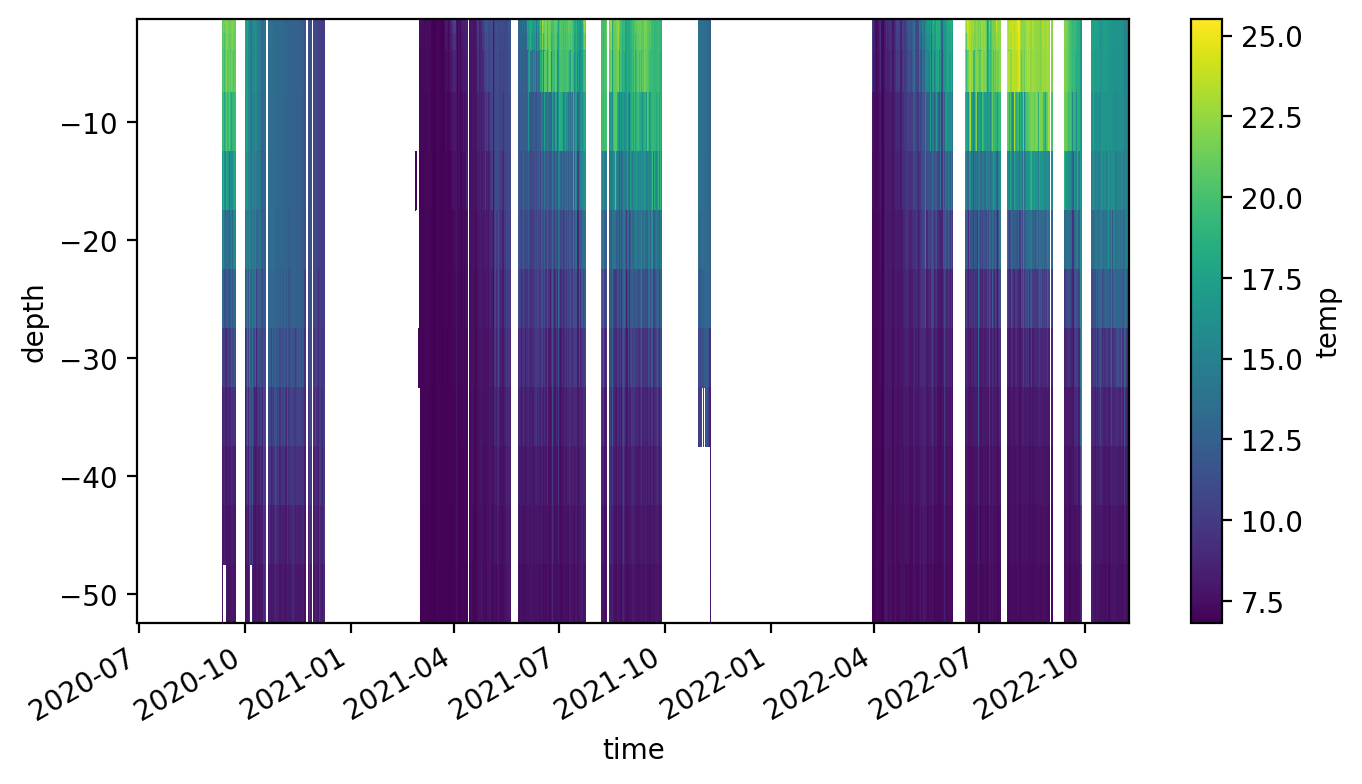

In [13]:
# plotting overview of one variable, in this case chlorophyll
# you can have a look at other data sets
fig = plt.figure(figsize=(8, 4), dpi= 200)
thetis.temp.transpose().plot()

# turn xarray in numpy arrays

This will give you the numpy arrays that need filling (target) and the co-variates that we can use for the filling process.

In [14]:
# list of variables in our datasets
idronaut_thetis_ctd_dict=list(thetis.keys())
meteo_dict=list(meteo.keys())

In [15]:
list_of_covariates=[]

In [16]:
# add thetis data to list of co-variates
for i in idronaut_thetis_ctd_dict:
    list_of_covariates.append(thetis[i].values)
# add day of year and hour of day to list of co-variates
list_of_covariates.append(thetis.time.dt.dayofyear.values)
list_of_covariates.append(thetis.time.dt.hour.values)

In [17]:
# add idronaut data to list of co-variates
for i in idronaut_thetis_ctd_dict:
    list_of_covariates.append(idronaut[i].values)

In [18]:
# add ctd data to list of co-variates
for i in idronaut_thetis_ctd_dict:
    list_of_covariates.append(ctd[i].values)

In [19]:
# add temperature chain data to list of co-variates
list_of_covariates.append(tchain[idronaut_thetis_ctd_dict[1]].values.transpose())

In [20]:
# add weather data to list of co-variates
for i in meteo_dict:
    list_of_covariates.append(meteo[i].values)

In [21]:
list_of_covariates[0].shape # lake data is 2 dimensional (3449 time steps, 14 depth levels)

(3449, 14)

In [22]:
list_of_covariates[-1].shape # weather data is 1 dimensional (3449 time steps)

(3449,)

In [23]:
data_to_fill=thetis["chla"].values

In [24]:
data_to_fill.shape # 3449 time steps, 14 depth levels

(3449, 14)

In [25]:
thetis_covariate_1=list_of_covariates[0] # that would be the same as data_to_fill in this case
# can be extended to N covariates of course

# start gap filling process here

In [26]:
print("to be filled by UNIL team")

to be filled by UNIL team


# numpy array to xarray

once the filled numpy array has been produced, this is how to convert it back to xarray

In [27]:
da = xr.DataArray(data=data_to_fill,dims=thetis.chla.dims,coords=thetis.chla.coords,attrs=dict(description="Chlorophyll A",units="units",),)

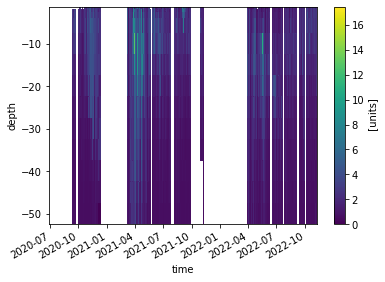

In [28]:
da.transpose().plot()

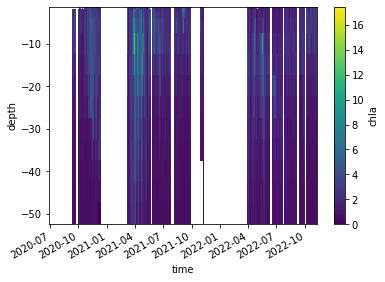

In [29]:
thetis.chla.transpose().plot()